In [1]:
import numpy as np

import torch
from torch import nn

import wandb

import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [2]:
def gen_data(n: int):
    scale = 4.
    centers = np.array([
        [1, 0],
        [-1, 0],
        [0, 1],
        [0, -1],
        [1. / np.sqrt(2), 1. / np.sqrt(2)],
        [1. / np.sqrt(2), -1. / np.sqrt(2)],
        [-1. / np.sqrt(2), 1. / np.sqrt(2)],
        [-1. / np.sqrt(2), -1. / np.sqrt(2)]
    ])
    centers = scale * centers

    x = np.random.randn(n, 2)
    x = 0.5 * x

    center_ids = np.random.randint(0, 8, n)
    x = x + centers[center_ids]

    x = x / 2 ** 0.5

    x = x.astype(np.float32)

    return x

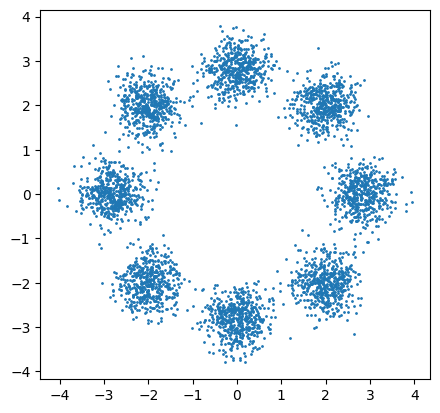

In [3]:
data_sample = gen_data(2 ** 12)

plt.scatter(data_sample[:, 0], data_sample[:, 1], s=1)
plt.axis("scaled")
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, out_dim),
        )
        
    def forward(self, t):
        return self.net(t)

In [5]:
class Affine(nn.Module):
    """
    Affine transformation module. It parametrizes the forward
    process of the diffusion model with a Gaussian distribution.

    F(x, t, eps) = \mu(x, t) + \sigma(x, t) * eps
    """

    def __init__(self):
        super().__init__()
        
        self.net = Net(3, 4)
        
    def forward(self, x, t):
        # Conditional optimal transport (FM-OT)
        # return (1 - t) * x, t + (1 - t) * 0.01

        # Learnable Gaussian forward process (NFDM-Gaussian)
        x_t = torch.cat([x, t], dim=1)
        m_ls = self.net(x_t)
        m, ls = m_ls.chunk(2, dim=1)

        m = (1 - t) * x + t * (1 - t) * m
        ls = (1 - t) * np.log(0.01) + t * (1 - t) * ls

        return m, torch.exp(ls)

In [6]:
class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = Net(3, 2)
        
    def forward(self, z, t):
        z_t = torch.cat([z, t], dim=1)
        x = self.net(z_t)

        # Reparametrization for numerical stability
        x = (1 - t) * z + (t + 0.01) * x
        
        return x

In [7]:
class Volatility(nn.Module):
    """
    Volatility module. It parametrizes the volatility g of the reverse and forward processes.

    d z = f(z, t) d t + g(t) d \bar{w}_t
                        ^^^^
    """
    def __init__(self):
        super().__init__()
        
        self.net = Net(1, 1)
        self.sp = nn.Softplus()
        
    def forward(self, t):
        # Volatility, that corresponds to linear log-SNR schedule in DDPM/VDM
        # return (20 * torch.sigmoid(-10 + 20 * t)) ** 0.5

        # Learnable volatility
        return self.sp(self.net(t))

In [8]:
def jvp(f, x, v):
    return torch.autograd.functional.jvp(
        f, x, v, 
        create_graph=torch.is_grad_enabled()
    )

def t_dir(f, t):
    return jvp(f, t, torch.ones_like(t))

In [9]:
class NeuralDiffusion(nn.Module):
    def __init__(self, affine, pred, vol):
        super().__init__()
        
        self.affine = affine
        self.pred = pred
        self.vol = vol
        
    def forward(self, x, t):
        def f(x_in):
            def f_(t_in):
                return self.affine(x_in, t_in)
            return f_

        g2 = self.vol(t) ** 2

        # compute parameters of q(z_t | x) and corresponding time derivatives
        (f_m, f_s), (f_dm, f_ds) = t_dir(f(x), t)

        # sample z_t from q(z_t | x)
        eps = torch.randn_like(x)
        z = f_m + f_s * eps

        # compute the drift term of the forward process based on eps
        f_dz = f_dm + f_ds * eps  # ODE drift
        f_score = - eps / f_s  # score function
        f_drift = f_dz - 0.5 * g2 * f_score  # SDE drift

        # predict x from z_t
        x_ = self.pred(z, t)

        # substitute predicted \hat{x} into the forward process to parameterise the reverse process
        (r_m, r_s), (r_dm, r_ds) = t_dir(f(x_), t)

        # compute the drift term of the reverse process based on z_t
        r_dz = r_dm + r_ds / r_s * (z - r_m)  # ODE drift
        r_score = (r_m - z) / r_s ** 2  # score function
        r_drift = r_dz - 0.5 * g2 * r_score  # SDE drift

        # compute the diffusion loss
        loss = 0.5 * (f_drift - r_drift) ** 2 / g2
        loss = loss.sum(dim=1)
        
        return loss

In [10]:
def train(model):
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    wandb.init(project="public_diffusion")

    for _ in trange(10 ** 2):
        x = torch.tensor(gen_data(2 ** 10))
        t = torch.rand(x.shape[0], 1)
        
        loss = model(x, t).mean()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        wandb.log({"loss": loss.item()})

In [11]:
affine = Affine()
pred = Predictor()
vol = Volatility()
ndm = NeuralDiffusion(affine, pred, vol)

In [12]:
train(ndm)

wandb: Currently logged in as: nmidavaine (nmidavaine-university-of-amsterdam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 100/100 [00:01<00:00, 60.75it/s]


In [16]:
@torch.no_grad()
def solve_sde(sde, z, ts, tf, n_steps):
    bs = z.shape[0]
    
    tt = torch.linspace(ts, tf, n_steps + 1)[1:]
    print(tt)
    dt = (tf - ts) / n_steps
    dt_2 = abs(dt) ** 0.5
    
    path = [z]
    for t in tqdm(tt):
        t = t.expand(bs, 1)
        
        f, g = sde(z, t)
        w = torch.randn_like(z)
        z = z + f * dt + g * w * dt_2
        
        path.append(z)
        
    return z, torch.stack(path)

tensor([0.9967, 0.9933, 0.9900, 0.9867, 0.9833, 0.9800, 0.9767, 0.9733, 0.9700,
        0.9667, 0.9633, 0.9600, 0.9567, 0.9533, 0.9500, 0.9467, 0.9433, 0.9400,
        0.9367, 0.9333, 0.9300, 0.9267, 0.9233, 0.9200, 0.9167, 0.9133, 0.9100,
        0.9067, 0.9033, 0.9000, 0.8967, 0.8933, 0.8900, 0.8867, 0.8833, 0.8800,
        0.8767, 0.8733, 0.8700, 0.8667, 0.8633, 0.8600, 0.8567, 0.8533, 0.8500,
        0.8467, 0.8433, 0.8400, 0.8367, 0.8333, 0.8300, 0.8267, 0.8233, 0.8200,
        0.8167, 0.8133, 0.8100, 0.8067, 0.8033, 0.8000, 0.7967, 0.7933, 0.7900,
        0.7867, 0.7833, 0.7800, 0.7767, 0.7733, 0.7700, 0.7667, 0.7633, 0.7600,
        0.7567, 0.7533, 0.7500, 0.7467, 0.7433, 0.7400, 0.7367, 0.7333, 0.7300,
        0.7267, 0.7233, 0.7200, 0.7167, 0.7133, 0.7100, 0.7067, 0.7033, 0.7000,
        0.6967, 0.6933, 0.6900, 0.6867, 0.6833, 0.6800, 0.6767, 0.6733, 0.6700,
        0.6667, 0.6633, 0.6600, 0.6567, 0.6533, 0.6500, 0.6467, 0.6433, 0.6400,
        0.6367, 0.6333, 0.6300, 0.6267, 

100%|██████████| 300/300 [00:02<00:00, 123.33it/s]


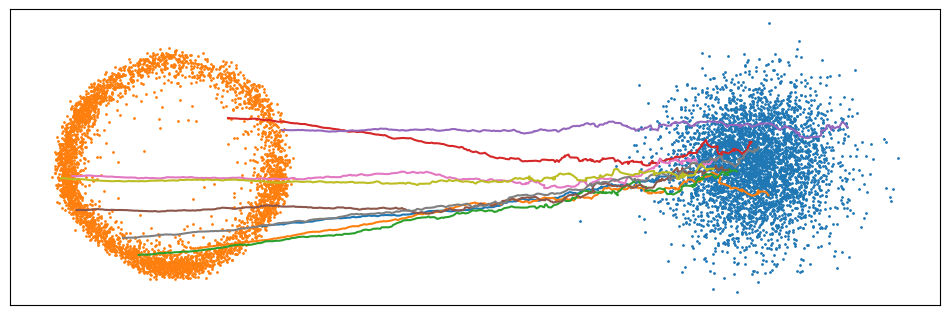

In [17]:
def sde_drift(z, t):
    x = pred(z, t)

    def f(t_in):
        return affine(x, t_in)

    (m, s), (dm, ds) = t_dir(f, t)
    g = vol(t)
    g2 = g ** 2

    dz = dm + ds / s * (z - m)
    score = (m - z) / s ** 2
    drift = dz - 0.5 * g2 * score

    return drift, g

z_1 = torch.randn(2 ** 12, 2)
_, z_path = solve_sde(sde_drift, z_1, 1, 0, 300)

t_steps = torch.linspace(1, 0, 301)

plt.figure(figsize=(12, 12))
plt.scatter(15 + z_path[0, :, 0], z_path[0, :, 1], s=1)
plt.scatter(z_path[-1, :, 0], z_path[-1, :, 1], s=1)
plt.plot(15 * t_steps[:, None] + z_path[:, :9, 0], z_path[:, :9, 1])
plt.axis("scaled")
plt.tick_params(left=False, labelleft=False,
                bottom=False, labelbottom=False)
plt.show()

tensor([1.0000, 0.9967, 0.9933, 0.9900, 0.9867, 0.9833, 0.9800, 0.9767, 0.9733,
        0.9700, 0.9667, 0.9633, 0.9600, 0.9567, 0.9533, 0.9500, 0.9467, 0.9433,
        0.9400, 0.9367, 0.9333, 0.9300, 0.9267, 0.9233, 0.9200, 0.9167, 0.9133,
        0.9100, 0.9067, 0.9033, 0.9000, 0.8967, 0.8933, 0.8900, 0.8867, 0.8833,
        0.8800, 0.8767, 0.8733, 0.8700, 0.8667, 0.8633, 0.8600, 0.8567, 0.8533,
        0.8500, 0.8467, 0.8433, 0.8400, 0.8367, 0.8333, 0.8300, 0.8267, 0.8233,
        0.8200, 0.8167, 0.8133, 0.8100, 0.8067, 0.8033, 0.8000, 0.7967, 0.7933,
        0.7900, 0.7867, 0.7833, 0.7800, 0.7767, 0.7733, 0.7700, 0.7667, 0.7633,
        0.7600, 0.7567, 0.7533, 0.7500, 0.7467, 0.7433, 0.7400, 0.7367, 0.7333,
        0.7300, 0.7267, 0.7233, 0.7200, 0.7167, 0.7133, 0.7100, 0.7067, 0.7033,
        0.7000, 0.6967, 0.6933, 0.6900, 0.6867, 0.6833, 0.6800, 0.6767, 0.6733,
        0.6700, 0.6667, 0.6633, 0.6600, 0.6567, 0.6533, 0.6500, 0.6467, 0.6433,
        0.6400, 0.6367, 0.6333, 0.6300, 

100%|██████████| 300/300 [00:02<00:00, 139.96it/s]


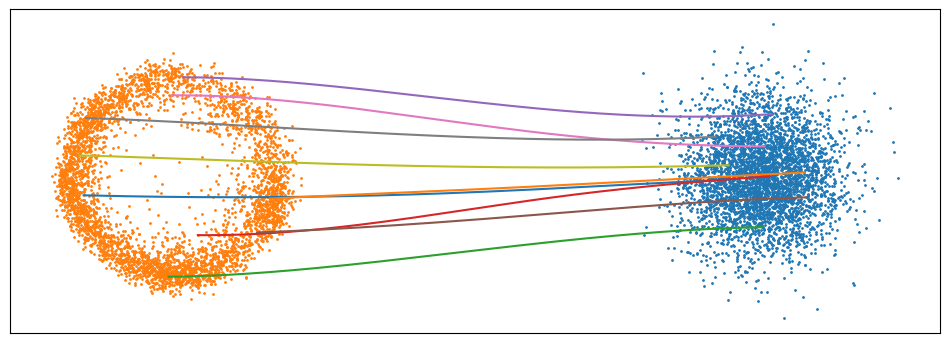

In [15]:
def ode_drift(z, t):
    x = pred(z, t)

    def f(t_in):
        return affine(x, t_in)

    (m, s), (dm, ds) = t_dir(f, t)

    dz = dm + ds / s * (z - m)

    return dz, 0

z_1 = torch.randn(2 ** 12, 2)
_, z_path = solve_sde(ode_drift, z_1, 1, 0, 300)

t_steps = torch.linspace(1, 0, 301)

plt.figure(figsize=(12, 12))
plt.scatter(15 + z_path[0, :, 0], z_path[0, :, 1], s=1)
plt.scatter(z_path[-1, :, 0], z_path[-1, :, 1], s=1)
plt.plot(15 * t_steps[:, None] + z_path[:, :9, 0], z_path[:, :9, 1])
plt.axis("scaled")
plt.tick_params(left=False, labelleft=False,
                bottom=False, labelbottom=False)
plt.show()

In [6]:
import torch
t = torch.tensor(0.5)
t = t.expand(64,1,1)
print(t)
if (t > 0.3).all():
    print("yes")

tensor([[[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5000]],

        [[0.5